### LIBRARIES

In [1]:
import time
import numpy as np
import pandas as pd
import datetime as dt

from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as st
import empiricaldist as emd
import thinkstats as ts
import utils as ut

from category_encoders import TargetEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer, log_loss, brier_score_loss, accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

from sklearn.pipeline import Pipeline

import warnings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

### CLEANING AND VALIDATION

In [3]:
original_data = pd.read_csv('ecom_data.csv', encoding='unicode_escape', parse_dates=['InvoiceDate'])

df = original_data.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


In [4]:
def timeseries_data_summary(dataframe, date_column):
    print(dataframe[date_column].min(), dataframe[date_column].max(), '\n##############\n')

    print(dataframe.info(), '\n##############\n')

    print(pd.DataFrame(dataframe.describe([.003, .01, .025, .05, .975, .99, .997])).T)

In [5]:
timeseries_data_summary(df, 'InvoiceDate')

# There are some nulls in Description and CustomerID.

2010-12-01 08:26:00 2011-12-09 12:50:00 
##############

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None 
##############

                 count                           mean                  min                 0.3%                   1%                 2.5%  \
Quantity    541909.000                          9.552           -80995.000              

In [6]:
# Investigating observations with unit price less than 0

df.loc[df['UnitPrice'] < 0, :].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.060,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.060,NaN,United Kingdom


In [7]:
# That A in front of the InvoiceNo stands for "adjust", probably. I'm gonna drop these two

print(len(df))
df = df.loc[df['UnitPrice'] >= 0, :]
print(len(df))

541909
541907


In [8]:
# What does it mean for the price to be zero?

df.loc[df['UnitPrice'] == 0, :].head(15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.000,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.000,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.000,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.000,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.000,NaN,United Kingdom
1988,536550,85044,NaN,1,2010-12-01 14:34:00,0.000,NaN,United Kingdom
2024,536552,20950,NaN,1,2010-12-01 14:34:00,0.000,NaN,United Kingdom
2025,536553,37461,NaN,3,2010-12-01 14:35:00,0.000,NaN,United Kingdom
2026,536554,84670,NaN,23,2010-12-01 14:35:00,0.000,NaN,United Kingdom
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.000,NaN,United Kingdom


In [9]:
df.loc[df['UnitPrice'] == 0, 'CustomerID'].value_counts(dropna=False)

CustomerID
NaN          2475
13081.000       4
14646.000       4
14911.000       2
13985.000       2
12415.000       2
16560.000       1
15107.000       1
13239.000       1
13113.000       1
12457.000       1
14410.000       1
17667.000       1
16818.000       1
17560.000       1
12647.000       1
15581.000       1
12507.000       1
12748.000       1
16133.000       1
12446.000       1
18059.000       1
14110.000       1
15804.000       1
12437.000       1
12431.000       1
13014.000       1
15602.000       1
12603.000       1
12444.000       1
16406.000       1
13256.000       1
Name: count, dtype: int64

In [10]:
# It's tough to make a meaning out of those, many of them does not even have a CustomerID.

df.loc[df['UnitPrice'] == 0, :].shape

(2515, 8)

In [11]:
# I'm dropping those as well, since I don't have necessary information to make sense at first glance.

df = df.loc[df['UnitPrice'] > 0, :]
df.shape

(539392, 8)

In [12]:
# Let's check out invoices that have 'C' on their identifier, it stands for "cancel" I suppose.

df.loc[df['InvoiceNo'].str.contains('C'), :].head(30)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.500,14527.000,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.650,15311.000,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.650,17548.000,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.290,17548.000,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.450,17548.000,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.650,17548.000,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.650,17548.000,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.250,17897.000,United Kingdom


In [13]:
df.loc[(df['InvoiceNo'].str.startswith('C')) & (df['Quantity'] >= 0), :].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [14]:
print(df.loc[df['InvoiceNo'].str.contains('C'), 'InvoiceDate'].min(), df.loc[df['InvoiceNo'].str.contains('C'), 'InvoiceDate'].max())

2010-12-01 09:41:00 2011-12-09 11:58:00


While creating variables, I need to make sure that I have that data available chronologically. To not deal with it immediately, and to set the baseline, I may start with creating variables regarding invoices.

In [15]:
# I'll make quantities and unitprices > 0 by taking their absolute, since I can already identify canceled orders via their InvoiceNo

df['Quantity'] = abs(df['Quantity'])

df.loc[df['UnitPrice'] < 0, :].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


### DATA PROCESSING

Before creating variables, as I understand:

* InvoiceNo: Unique identifier of the invoice
* StockCode: Unique identifier of the item
* Description: Description of the item
* Quantity: Amount of that item that has been included in the order
* InvoiceDate: Date of the invoice
* UnitPrice: Price value of one unit of that item
* CustomerID: Unique identifier of the customer
* Country: Where the order has been created from

In [16]:
def create_dt_feats(dataframe):
    dataframe['year'] = dataframe.InvoiceDate.dt.year
    dataframe['month'] = dataframe.InvoiceDate.dt.month
    dataframe['day_of_month'] = dataframe.InvoiceDate.dt.day
    dataframe['month_start'] = dataframe.InvoiceDate.dt.is_month_start.astype(int)
    dataframe['month_end'] = dataframe.InvoiceDate.dt.is_month_end.astype(int)
    dataframe['weekend'] = dataframe.InvoiceDate.dt.weekday // 4
    dataframe['day_of_year'] = dataframe.InvoiceDate.dt.dayofyear
    
    return dataframe[['InvoiceNo', 'InvoiceDate', 'year', 'month', 'day_of_month', 'month_start', 'month_end', 'weekend', 'day_of_year']].drop_duplicates()

def process_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process invoice-level data to prepare features for modeling.
    
    Parameters
    ----------
    df : pd.DataFrame
        The raw dataset with columns including InvoiceNo, Country, Quantity, UnitPrice, StockCode, etc.
    
    Returns
    -------
    pd.DataFrame
        A processed DataFrame for modeling.
    """
    # 1. Create invoice-level DataFrame
    new_df = pd.DataFrame(df.InvoiceNo.unique().tolist(), columns=['InvoiceNo'])
    
    # 2. Create the target variable (if InvoiceNo contains 'C')
    new_df['returned'] = 0
    returned_invs = df.loc[df['InvoiceNo'].str.contains('C'), 'InvoiceNo'].unique().tolist()
    new_df.loc[new_df.InvoiceNo.isin(returned_invs), 'returned'] = 1
    
    # 3. Add country info (drop duplicates first)
    new_df = new_df.merge(df[['InvoiceNo', 'Country']].drop_duplicates(), on='InvoiceNo', how='left')
    
    # 4. Price of an item x how many did the customer order
    df['total_price'] = df['Quantity'] * df['UnitPrice']
    
    # 5. Categorical variables out of StockCode
    df['stock_code_char'] = df['StockCode'].str.extract(r'([A-Z]+)')
    df = df.loc[~df['stock_code_char'].isin(['BANK', 'POST', 'AMAZONFEE', 'CRUK']), :] # get rid of non-related to product stock codes.
    df['stock_code_char'] = df['stock_code_char'].fillna('NONE')

    stock_code_counts = df.groupby(['InvoiceNo', 'stock_code_char']).agg(
    counts = ('stock_code_char', 'value_counts'),
    n_item = ('Quantity', np.sum)
    ).reset_index()
    stock_code_pvt = pd.pivot_table(stock_code_counts, index='InvoiceNo', values='counts', columns='stock_code_char').reset_index().fillna(0)
    new_df = new_df.merge(stock_code_pvt, how='left', on=['InvoiceNo'])
    
    # 6. Aggregate to invoice level: total quantity, total price, number of unique items
    agg_df = df.groupby('InvoiceNo').agg(
        total_quantity=('Quantity', 'sum'),
        total_price=('total_price', 'sum'),
        nunique_items=('StockCode', 'nunique')
    ).reset_index()
    new_df = new_df.merge(agg_df, how='left', on=['InvoiceNo']).rename(columns = {
    'StockCode':'nunique_items',
    'Quantity':'total_quantity'
    })
    
    # 7. Create date features and merge
    df_date = create_dt_feats(df)
    new_df = new_df.merge(df_date, how='left', on=['InvoiceNo'])

    return new_df


In [17]:
new_df = process_data(df)
new_df.head()

,InvoiceNo,returned,Country,A,B,BL,C,D,DCGS,DCGSSBOY,DCGSSGIRL,DOT,E,F,G,H,I,J,K,L,M,N,NONE,O,P,PADS,R,S,T,U,V,W,Y,Z,total_quantity,total_price,nunique_items,InvoiceDate,year,month,day_of_month,month_start,month_end,weekend,day_of_year
0,536365,0,United Kingdom,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,40.000,139.120,7.000,2010-12-01 08:26:00,2010.000,12.000,1.000,1.000,0.000,0.000,335.000
1,536366,0,United Kingdom,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.000,22.200,2.000,2010-12-01 08:28:00,2010.000,12.000,1.000,1.000,0.000,0.000,335.000
2,536367,0,United Kingdom,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,83.000,278.730,12.000,2010-12-01 08:34:00,2010.000,12.000,1.000,1.000,0.000,0.000,335.000
3,536368,0,United Kingdom,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,15.000,70.050,4.000,2010-12-01 08:34:00,2010.000,12.000,1.000,1.000,0.000,0.000,335.000
4,536369,0,United Kingdom,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,17.850,1.000,2010-12-01 08:35:00,2010.000,12.000,1.000,1.000,0.000,0.000,335.000


Within the same order, there can be more than one category of items. I may come up with lots of variables out of this, and see if they have any effect on the order cancellation.

Interactions can be created between nunique_items and stockcodechars, such as ratios. But we may have to let go of feature importance approaches.

### TOWARDS MODELING

These variables are _invoice-level_ variables, but certain features of customers can make the order to be less/more likely to be canceled. So, customer-level variables might be helpful as well. It's a bit tricky to create those: Modeller shouldn't use any information that is not chronologically available, and there are different approaches to deal with it.

Before diving to that:

* I'll make a model here to set a baseline with only invoice-level variables.

In [18]:
def data_split(dataframe, split_date='2011-11-01'):
    dataframe = dataframe.set_index('InvoiceNo')

    train = dataframe.loc[dataframe['InvoiceDate'] < split_date, :]
    test = dataframe.loc[dataframe['InvoiceDate'] >= split_date, :]

    return train.sort_values(by='InvoiceDate', ascending=True), test.sort_values(by='InvoiceDate', ascending=True)

In [19]:
train, test = data_split(new_df, split_date='2011-11-01')

print(
    train.shape,
    test.shape
)

(19476, 44) (4134, 44)


In [20]:
cat_cols = ['Country', 'month_start', 'month_end', 'weekend']
num_cols = [col for col in train.columns if col not in cat_cols and col not in ['InvoiceDate', 'returned']]
binary_cols = [col for col in cat_cols if train[col].nunique() == 2 and col != 'returned']

print(
    cat_cols,
    num_cols,
    binary_cols
)

['Country', 'month_start', 'month_end', 'weekend'] ['A', 'B', 'BL', 'C', 'D', 'DCGS', 'DCGSSBOY', 'DCGSSGIRL', 'DOT', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'NONE', 'O', 'P', 'PADS', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'total_quantity', 'total_price', 'nunique_items', 'year', 'month', 'day_of_month', 'day_of_year'] ['month_start', 'month_end', 'weekend']


In [21]:
for col in cat_cols:
    train[col] = train[col].astype('object')
    test[col] = test[col].astype('object')

### SOME SIMPLE EDA

In [22]:
def binary_eda(dataframe, binary_cols, target='returned'):

    for col in binary_cols:
        seq0 = dataframe.loc[train[target] == 0, col]
        seq1 = dataframe.loc[train[target] == 1, col]

        pmf0 = emd.Pmf.from_seq(seq0, name='0')
        pmf1 = emd.Pmf.from_seq(seq1, name='1')

        plt.figure(figsize=(6, 4))

        ts.two_bar_plots(pmf0, pmf1)

        plt.xticks([0, 1])
        plt.ylim([0, 1])

        plt.title('Column: ' + str(col))
        plt.legend()

        plt.show()

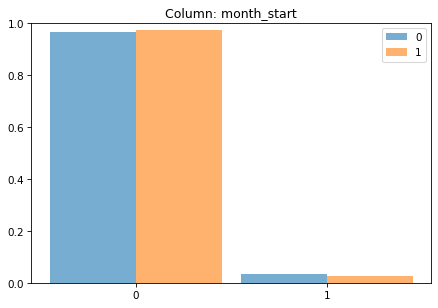

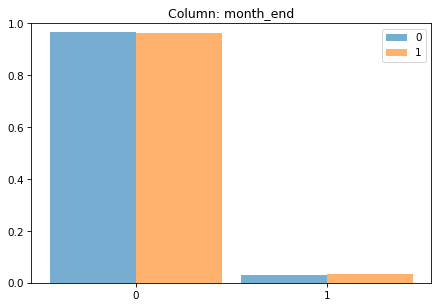

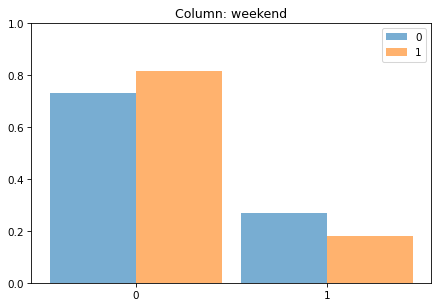

In [23]:
binary_eda(train, binary_cols=binary_cols, target='returned')

These are aggregated over each month in the training set, and in aggregate, only 'weekend' seems to have some main effect. Another interesting thing would be to check within months if you're interested in that type of patterns. However, our data is not probably good for it, since we don't have another year of data which corresponds to same month. But, I show a simple way to check it below.

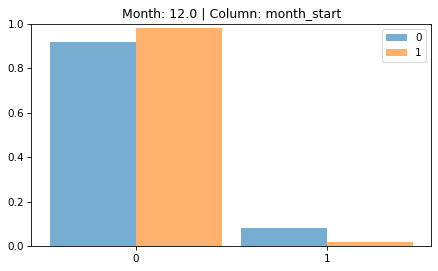

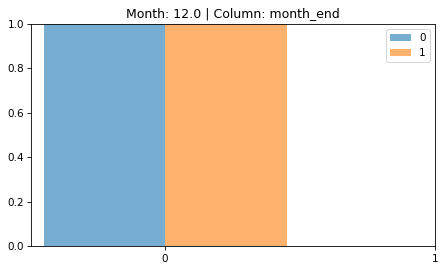

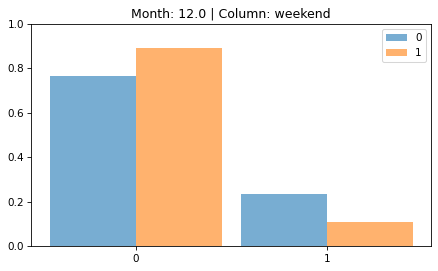

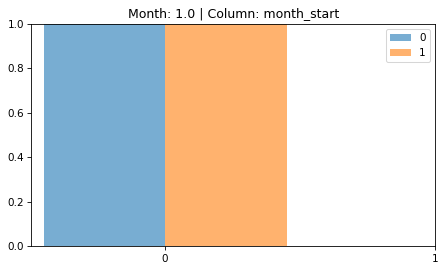

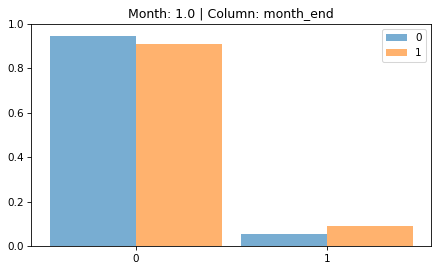

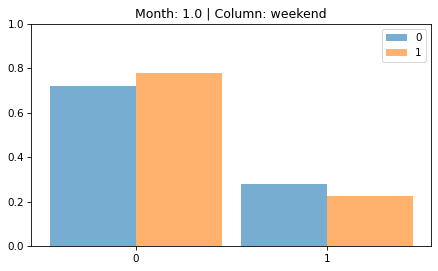

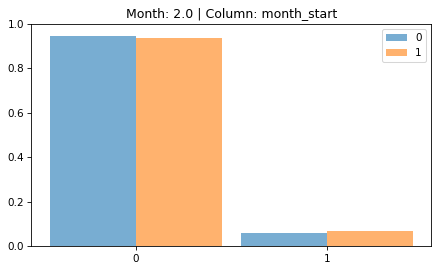

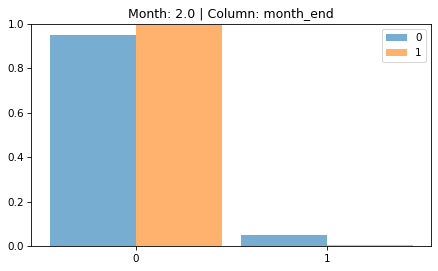

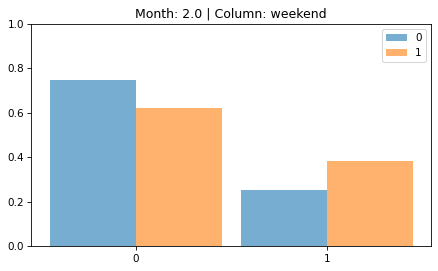

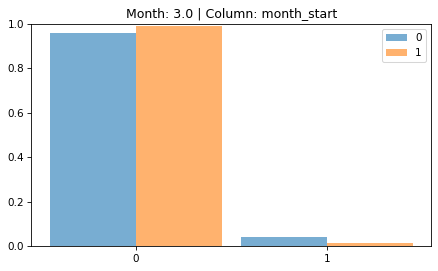

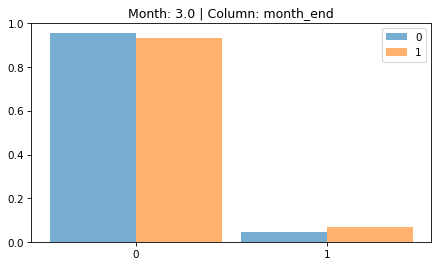

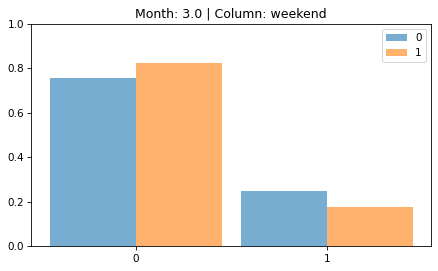

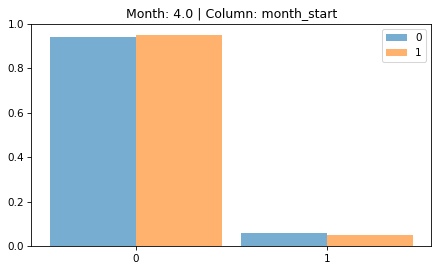

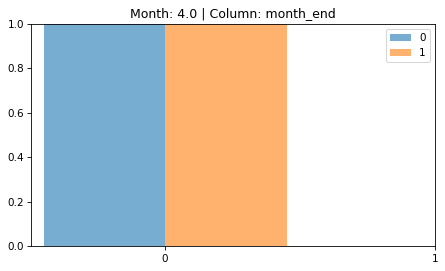

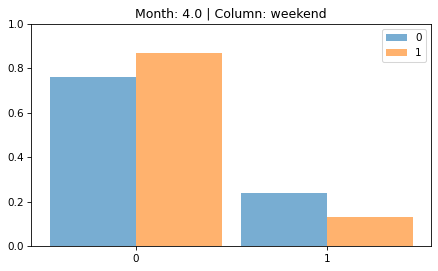

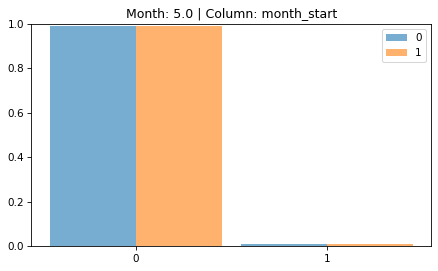

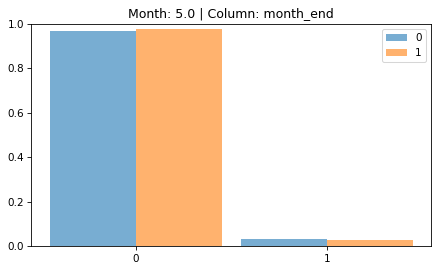

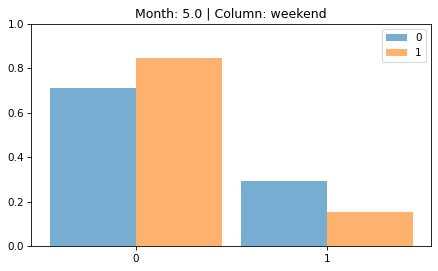

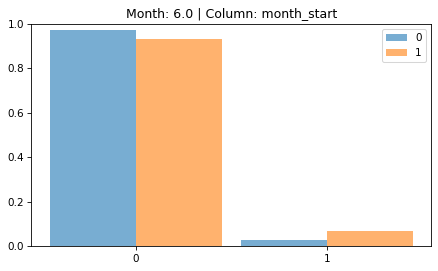

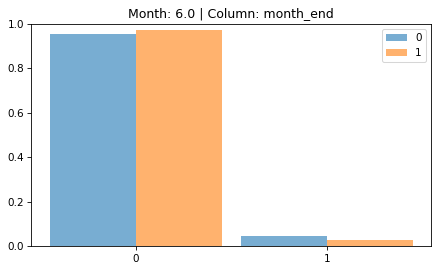

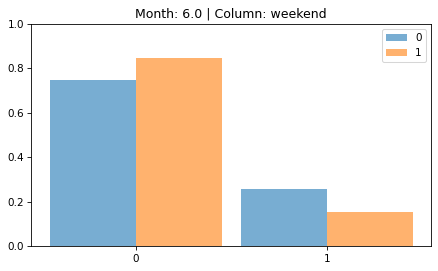

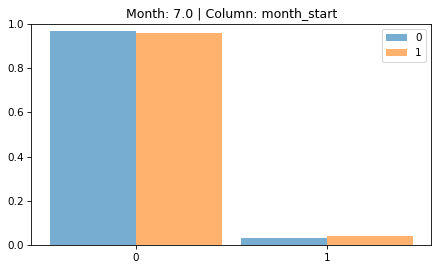

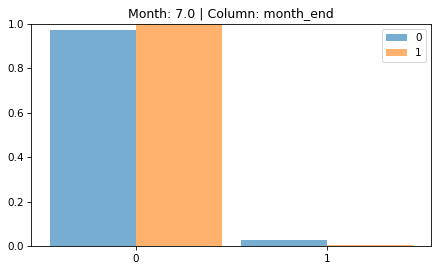

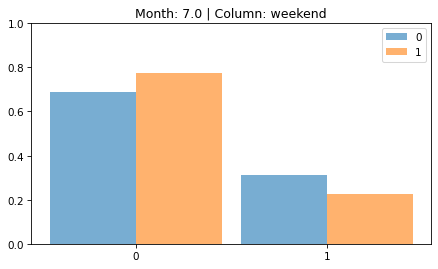

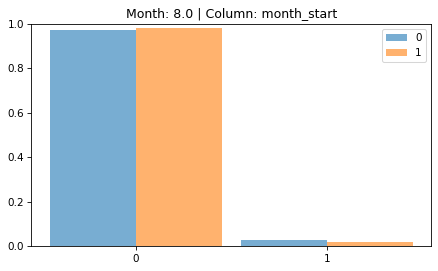

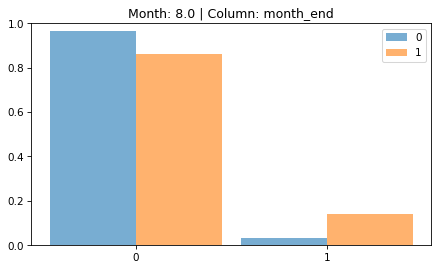

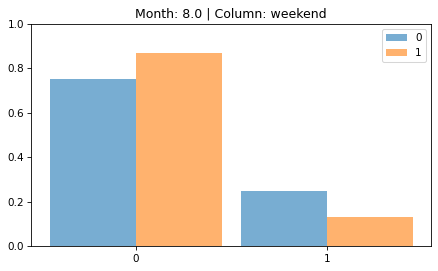

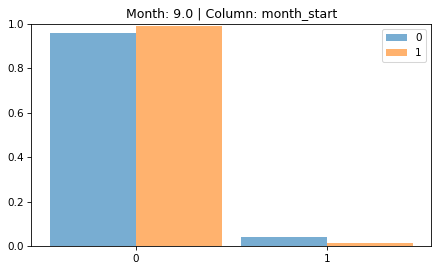

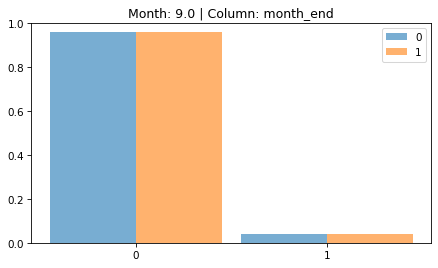

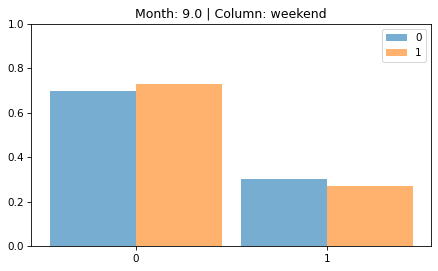

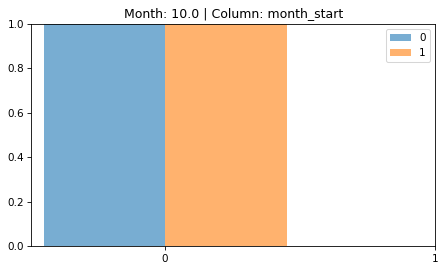

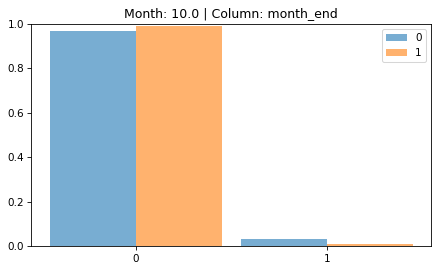

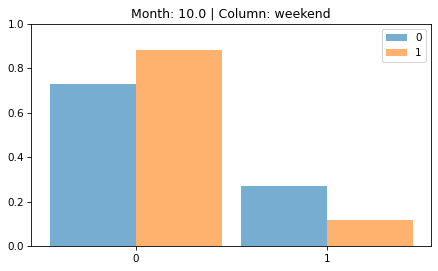

In [24]:
for month in train['month'].unique().tolist():

    for col in binary_cols:
        seq0 = train.loc[(train['month'] == month) & (train['returned'] == 0), col]
        seq1 = train.loc[(train['month'] == month) & (train['returned'] == 1), col]

        pmf0 = emd.Pmf.from_seq(seq0, name='0')
        pmf1 = emd.Pmf.from_seq(seq1, name='1')

        ts.two_bar_plots(pmf0, pmf1)

        plt.xticks([0, 1])
        plt.ylim([0, 1])

        plt.title('Month: ' + str(month) + ' | ' + 'Column: ' + str(col))
        plt.legend()

        plt.show()

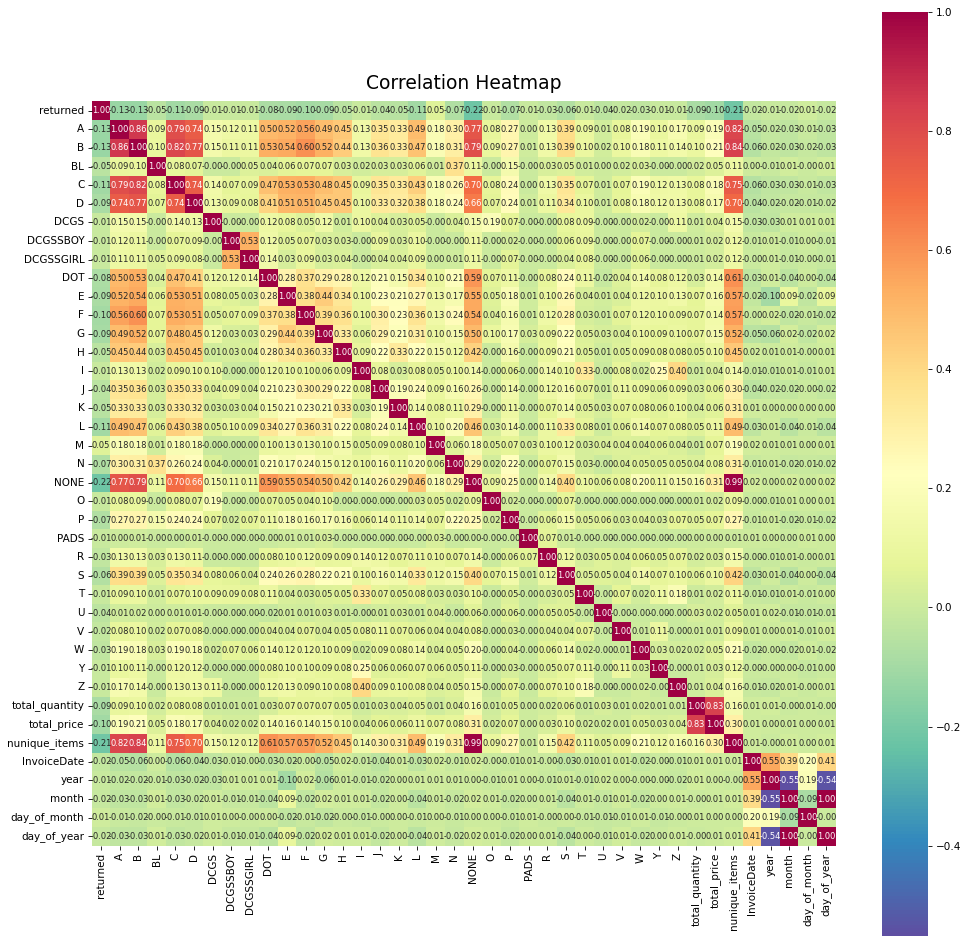

In [25]:
corrmat = train[[col for col in train.columns if train[col].dtype != 'object']].corr()

plt.figure(figsize=(16, 16))
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 8},
                 cmap="Spectral_r")
hm.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

plt.show()

In [26]:
train.drop('NONE', axis=1, inplace=True)
test.drop('NONE', axis=1, inplace=True)

In [27]:
def continuous_eda(dataframe, cols, n_bins=5):
    tmp_df = dataframe[cols + ['returned']].copy()

    for col in tmp_df.columns:
        if col != 'returned':
            tmp_df[col + '_binned'] = pd.cut(tmp_df[col], n_bins, labels=[num+1 for num in range(n_bins)], ordered=False)

            grouped_by = tmp_df.groupby(col + '_binned').agg({
                col:'mean',
                'returned':'mean'
            }).reset_index()

            jittered_xs = [np.random.normal(loc=0, scale=.09, size=1)[0] + val for val in tmp_df[col].values]

            plt.figure(figsize=(7,5))

            plt.plot(jittered_xs, tmp_df['returned'], 'o', alpha=.3, color='C10')
            plt.plot(grouped_by[col], grouped_by.returned, 'o', alpha=.5, color='black', markerfacecolor='white', markersize=8)

            plt.title(col)

            plt.legend()
            plt.show()
        else:
            pass

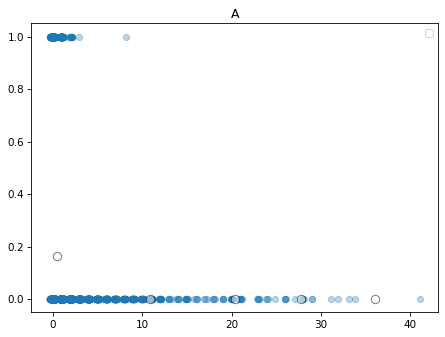

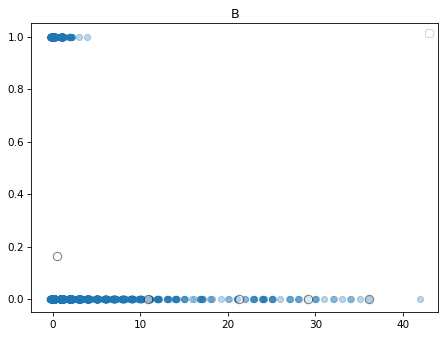

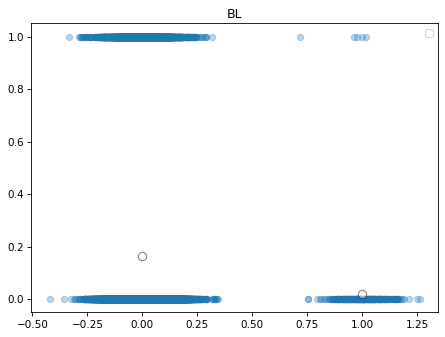

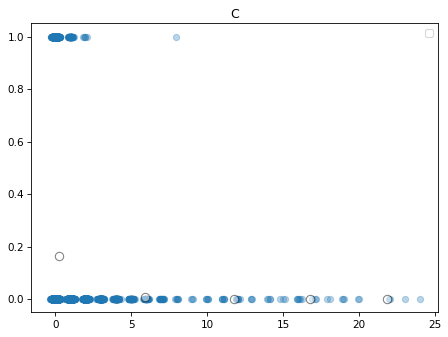

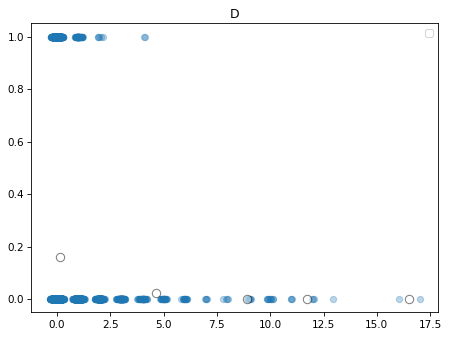

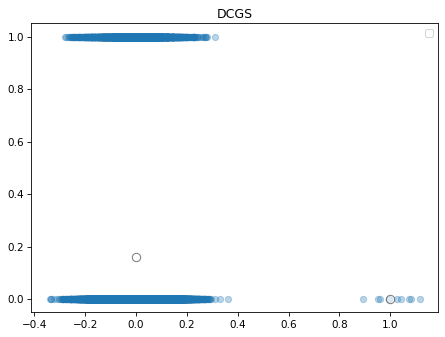

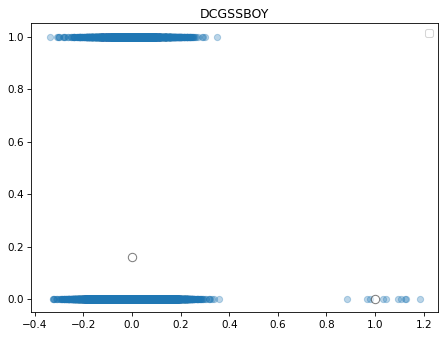

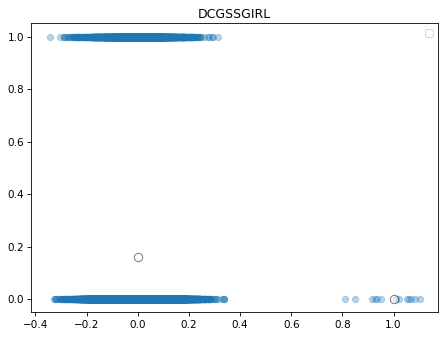

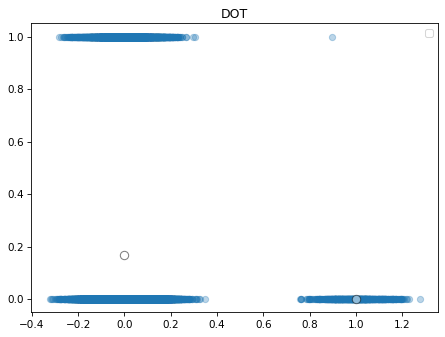

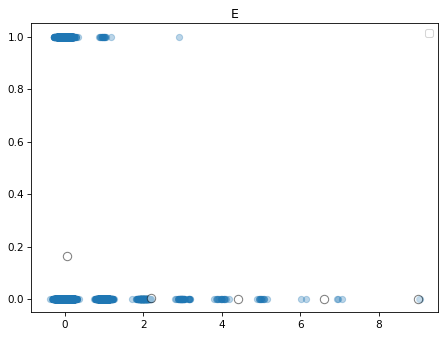

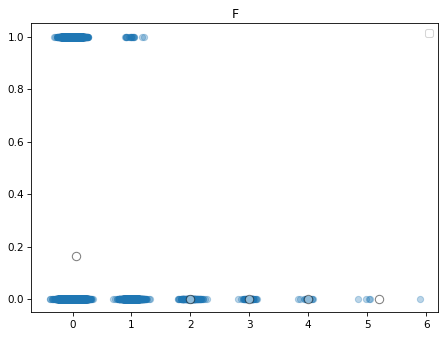

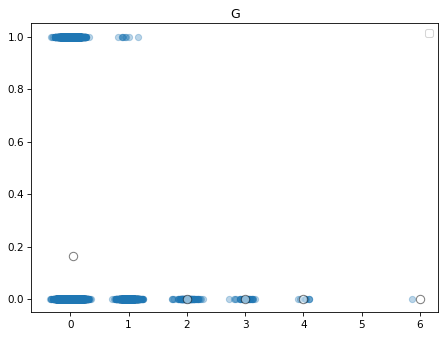

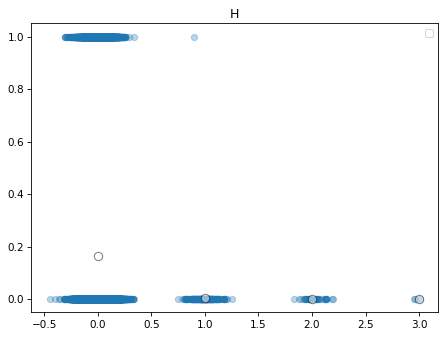

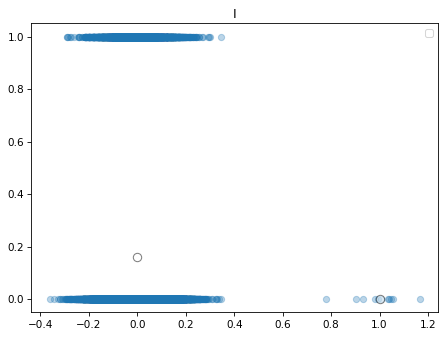

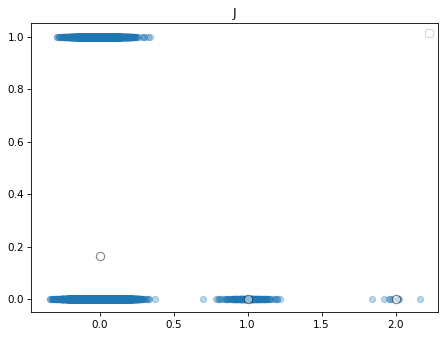

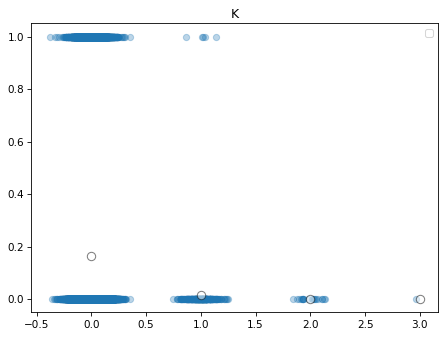

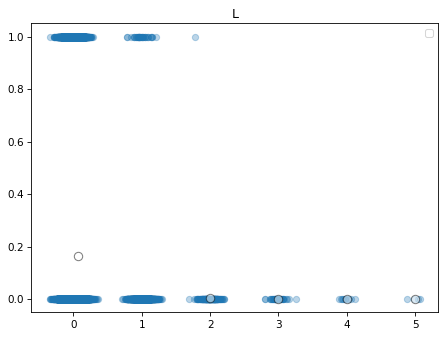

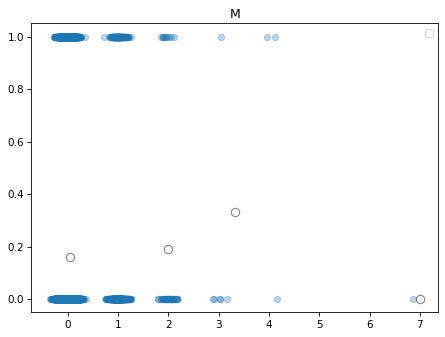

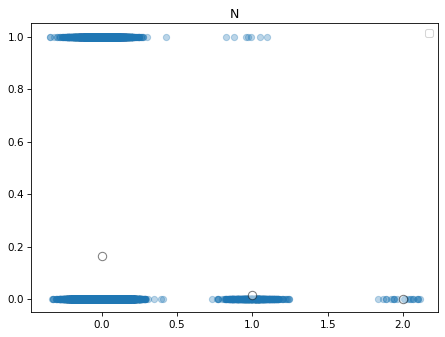

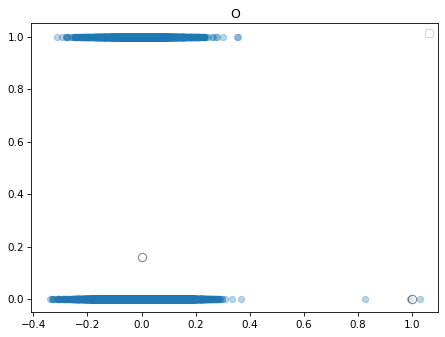

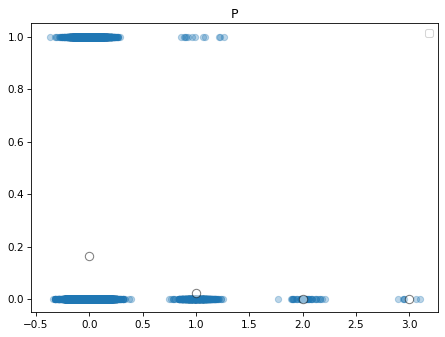

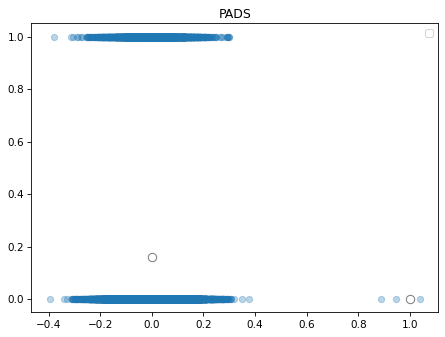

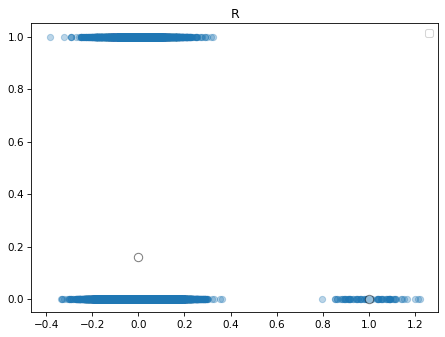

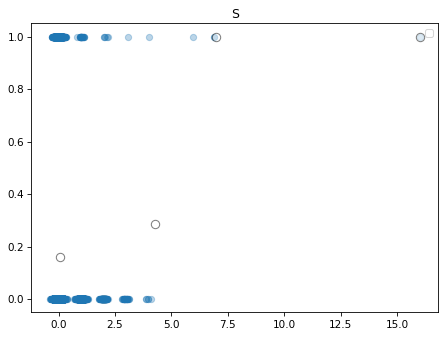

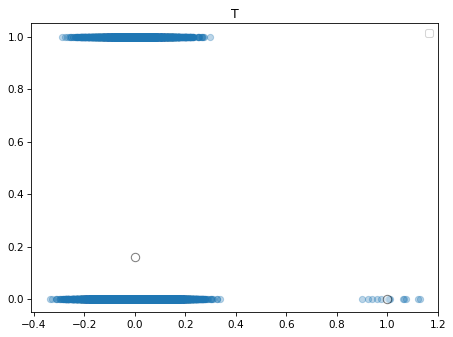

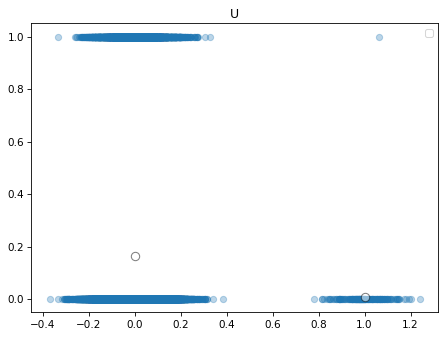

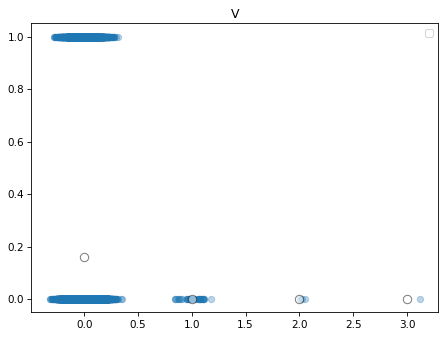

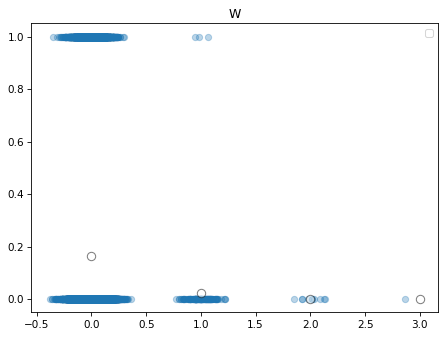

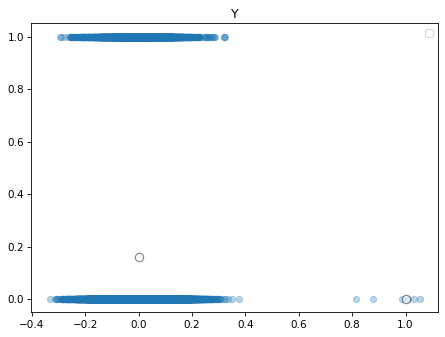

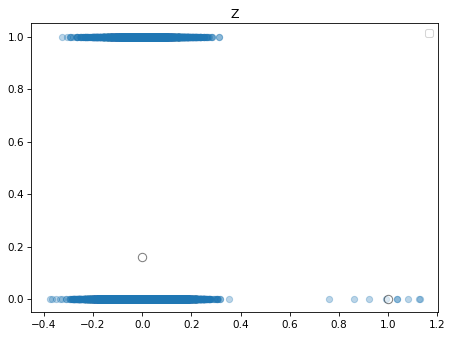

In [28]:
stockcode_chars = ['A', 'B', 'BL', 'C', 'D', 'DCGS', 'DCGSSBOY', 'DCGSSGIRL', 'DOT', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'PADS', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z']

continuous_eda(train, stockcode_chars)

Other than M and S, discretizing should increase signal-to-noise ratio.

In [29]:
for col in stockcode_chars:
    if col not in ['M', 'S']:
        train[col] = train[col].apply(lambda x: 1 if x != 0 else 0)
        test[col] = test[col].apply(lambda x: 1 if x != 0 else 0)
    else:
        pass

In [30]:
for col in [col for col in train.columns if train[col].nunique() == 2]:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19476 entries, 536365 to 573695
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   returned        19476 non-null  category      
 1   Country         19476 non-null  object        
 2   A               19476 non-null  category      
 3   B               19476 non-null  category      
 4   BL              19476 non-null  category      
 5   C               19476 non-null  category      
 6   D               19476 non-null  category      
 7   DCGS            19476 non-null  category      
 8   DCGSSBOY        19476 non-null  category      
 9   DCGSSGIRL       19476 non-null  category      
 10  DOT             19476 non-null  category      
 11  E               19476 non-null  category      
 12  F               19476 non-null  category      
 13  G               19476 non-null  category      
 14  H               19476 non-null  category      
 15  I

### MODELING

In [31]:
train.returned.value_counts(normalize=True)

returned
0   0.839
1   0.161
Name: proportion, dtype: float64

In [32]:
tscv = TimeSeriesSplit(n_splits=train.month.nunique())

In [33]:
X_train = train.drop(['returned', 'InvoiceDate', 'year', 'month'], axis=1)
y_train = train.returned

X_test = test.drop(['returned', 'InvoiceDate', 'year', 'month'], axis=1)
y_test = test.returned

In [34]:
def weighted_brier_score(y_true, y_pred_proba, **kwargs):
    if y_pred_proba.ndim > 1 and y_pred_proba.shape[1] == 2:
        y_pred_proba = y_pred_proba[:, 1]

    # Compute weights
    class_counts = np.bincount(y_true)
    weights = np.zeros_like(y_true, dtype=float)
    # for c in np.unique(y_true):
    #     weights[y_true == c] = 1.0 / class_counts[c]
    total = len(y_true)
    for c in np.unique(y_true):
        weights[y_true == c] = total / (2 * class_counts[c])


    return brier_score_loss(y_true, y_pred_proba, sample_weight=weights)

wbrier = make_scorer(weighted_brier_score, needs_proba=True, greater_is_better=False)

In [35]:
def weighted_log_loss(y_true, y_pred_proba, **kwargs):
    class_counts = np.bincount(y_true)
    weights = np.zeros_like(y_true, dtype=float)
    for c in np.unique(y_true):
        weights[y_true == c] = 1.0 / class_counts[c]
    
    return log_loss(y_true, y_pred_proba, sample_weight=weights)

wll = make_scorer(weighted_log_loss, needs_proba=True, greater_is_better=False)

In [36]:
models = [
    DecisionTreeClassifier(random_state=0),
    AdaBoostClassifier(random_state=0), 
    RandomForestClassifier(random_state=0), 
    LGBMClassifier(objective='binary', random_state=0), 
    XGBClassifier(seed=0, objective='binary:logistic', tree_method='hist', enable_categorical=True, use_label_encoder=False),
]


In [37]:
def get_model_params(classifier_type):
    # Return the parameter grid for each classifier.

    if classifier_type == DecisionTreeClassifier:
        return {
            'classifier__class_weight':['balanced'],
            'classifier__max_depth': (3, 12),
            'classifier__min_samples_split': (60, 180),
            'classifier__min_samples_leaf': (20, 80),
            'classifier__max_features': (0.2, 0.8, 'uniform')
        }

    elif classifier_type == AdaBoostClassifier:
        return {
            'classifier__n_estimators': (50, 450)
        }
    
    elif classifier_type == RandomForestClassifier:
        return {
            'classifier__class_weight':['balanced'],
            'classifier__bootstrap': [False, True],
            'classifier__max_depth': (4, 12),
            'classifier__max_features': (.3, 1., 'uniform'),
            'classifier__min_samples_leaf': (10, 50),
            'classifier__min_samples_split': (40, 160),
            'classifier__n_estimators': (100, 500)
        }
    
    elif classifier_type == LGBMClassifier:
        return {
            'classifier__class_weight':['balanced'],
            'classifier__num_leaves': (10, 90),    
            'classifier__learning_rate': (0.01, 0.2),
            'classifier__n_estimators': (50, 500),
            'classifier__colsample_bytree': (.1, 1.0),
            'classifier__max_depth': (3, 9),
            'classifier__min_child_samples': (15, 205)
        }
    
    elif classifier_type == XGBClassifier:

        scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

        return {
            'classifier__scale_pos_weight':[scale_pos_weight],
            'classifier__eta':(0.01 , 0.2),
            'classifier__gamma':(1, 300),
            'classifier__max_depth':(4, 9),
            'classifier__colsample_bytree':(0.1, 1.0, 'uniform'),
            'classifier__colsample_bylevel':(0.1, 1.0, 'uniform'),
            'classifier__n_estimators':(50, 500)
        }

def ml_tries(clfs, cv=TimeSeriesSplit(n_splits=train.month.nunique())):

    model_param_pairs = {}
    best_models = {}

    for clf in clfs:
        classifier_type = type(clf)
        print(f"Training {classifier_type.__name__}...")

        pipeline = Pipeline([
            ('target_encoder', TargetEncoder(cols=['Country'])),
            ('classifier', clf)
        ])

        params = get_model_params(classifier_type)

        bayes_search = BayesSearchCV(
            pipeline,
            params,
            n_iter=50,
            cv=cv.split(X_train, y_train),
            scoring=wll,
            n_jobs=-2,
            random_state=0
        )

        bayes_search.fit(X_train, y_train)

        best_models[clf] = bayes_search.best_estimator_
        model_param_pairs[clf] = [bayes_search.best_score_, bayes_search.best_params_]

    estimators = [(f"model_{i}", model) for i, model in enumerate(best_models.values())]

    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(),
        cv=5
    )

    stacking_clf.fit(X_train, y_train)

    return model_param_pairs, stacking_clf

Using "balanced" for *class_weights* adjusts the contribution of each level of the class so that to the total weights, each class contributes equally.

Then why do we still pass a custom cost function? Scorer is about calculation of the cost function. It doesn't specify fitting with weights. In other words, it does not affect how the model is trained (but affects which fit is the best). "Balanced" on the other hand, affects the way the model is fit (calculation of splits, gini etc. take weights into account).

In [38]:
model_dict, fin_clf = ml_tries(models)

Training DecisionTreeClassifier...
Training AdaBoostClassifier...
Training RandomForestClassifier...
Training LGBMClassifier...
[LightGBM] [Info] Number of positive: 3141, number of negative: 16335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 19476, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [39]:
te = TargetEncoder(cols=['Country']).fit(X_train, y_train)

X_train_2 = te.fit_transform(X_train, y_train)
X_test_2 = te.transform(X_test)

In [40]:
stacked_pred_probas = fin_clf.predict_proba(X_test)[:, 1]

<Axes: ylabel='Count'>

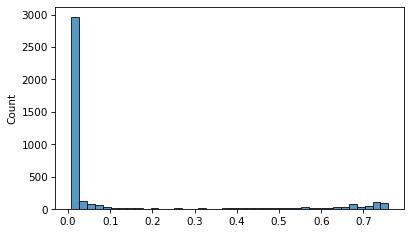

In [41]:
sns.histplot(stacked_pred_probas, bins=40)

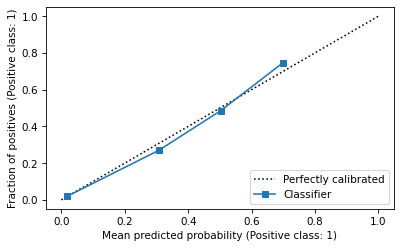

In [42]:
CalibrationDisplay.from_predictions(y_test, stacked_pred_probas)

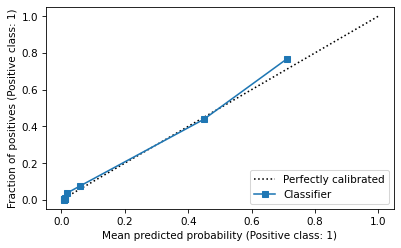

In [43]:
CalibrationDisplay.from_predictions(y_test, stacked_pred_probas, n_bins=10, strategy='quantile')

In [45]:
precision, recall, th = precision_recall_curve(y_test, np.where(stacked_pred_probas > 0.5, 1, 0))
pr_auc = auc(recall, precision)

print(f"Recall: {round(recall_score(y_test, np.where(stacked_pred_probas > 0.5, 1, 0)),3)}")
print(f"Precision: {round(precision_score(y_test, np.where(stacked_pred_probas > 0.5, 1, 0)), 3)}")
print(f"F1: {round(f1_score(y_test, np.where(stacked_pred_probas > 0.5, 1, 0)), 3)}")
print(f"PR_AUC: {round(pr_auc, 3)}")

Recall: 0.764
Precision: 0.719
F1: 0.741
PR_AUC: 0.758
